In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
from imutils import *
from process_groundTruth import interpolacionConcatenada
from tensorflow.keras.utils import plot_model

In [7]:
class paths:
    def __init__(self):
        self.a = 2
        self.b = 3

paths = paths()
paths.b

3

# Lectura del ground-truth

Leemos el ground-truth y leemos los logfiles obtenidos en diferentes momentos del día y dias. Seleccionamos aquellos wifis que aparezcan en todos los log-files

In [2]:
groundtruth = pd.read_csv("extendedData/final_groundtruth/groundtruth.csv")
def getMacsLog(dir):
    with open(dir, "r") as fich:
        macs = []
        for linea in fich.readlines():
            arr = linea.rstrip("\n").split(";")
            if arr[0]=="WIFI":
                macs.append(arr[3])
    return macs

macs_6_13_30 = set(getMacsLog("logfile_2023_10_06_13_30_33.txt"))
macs_10_6_18 = set(getMacsLog("logfile_2023_10_10_06_18_14.txt"))
macs_10_9_17 = set(getMacsLog("logfile_2023_10_10_09_17_34.txt"))

interseccion = list(macs_6_13_30 & macs_10_6_18 & macs_10_9_17 & set(groundtruth.columns.tolist()))
others = ["Acc_X", "Acc_Y", "Acc_Z", "Gyr_X", "Gyr_Y", "Gyr_Z", "Mag_X", "Mag_Y", "Mag_Z", "Latitude", "Longitude", "Label"]
new_columns = ["AppTimestamp(s)"] + interseccion + others
groundtruth = groundtruth[new_columns]
groundtruth_interpolated = interpolacionConcatenada(groundtruth)

# Preparado para introducir datos en GAN
$[RSSI_{AP_1}, RSSI_{AP_1}, \ldots, RSSI_{AP_8} ]$

Interpolación de los datos ausentes intercalados

Las primeras 60 muestras en cada label serán de entrenamiento, mientras que las otras 30 muestras serán de test

In [7]:
train_df = groundtruth_interpolated.query("`AppTimestamp(s)`<45").reset_index().drop("index", axis=1)
test_df = groundtruth_interpolated.query("`AppTimestamp(s)`>=45").reset_index().drop("index", axis=1)

wifi_columns = train_df.iloc[:,1:9].columns.tolist()
wifi_train = train_df[wifi_columns + ["Latitude", "Longitude", "Label"]]
wifi_test = test_df[wifi_columns + ["Latitude", "Longitude", "Label"]]

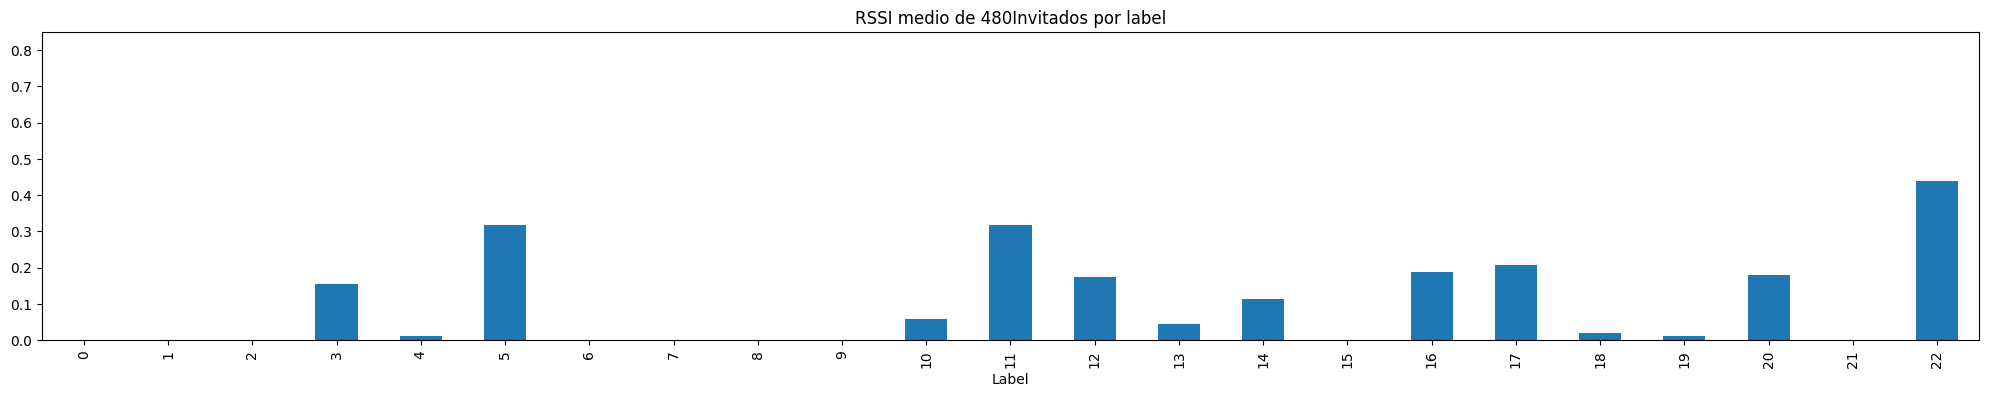

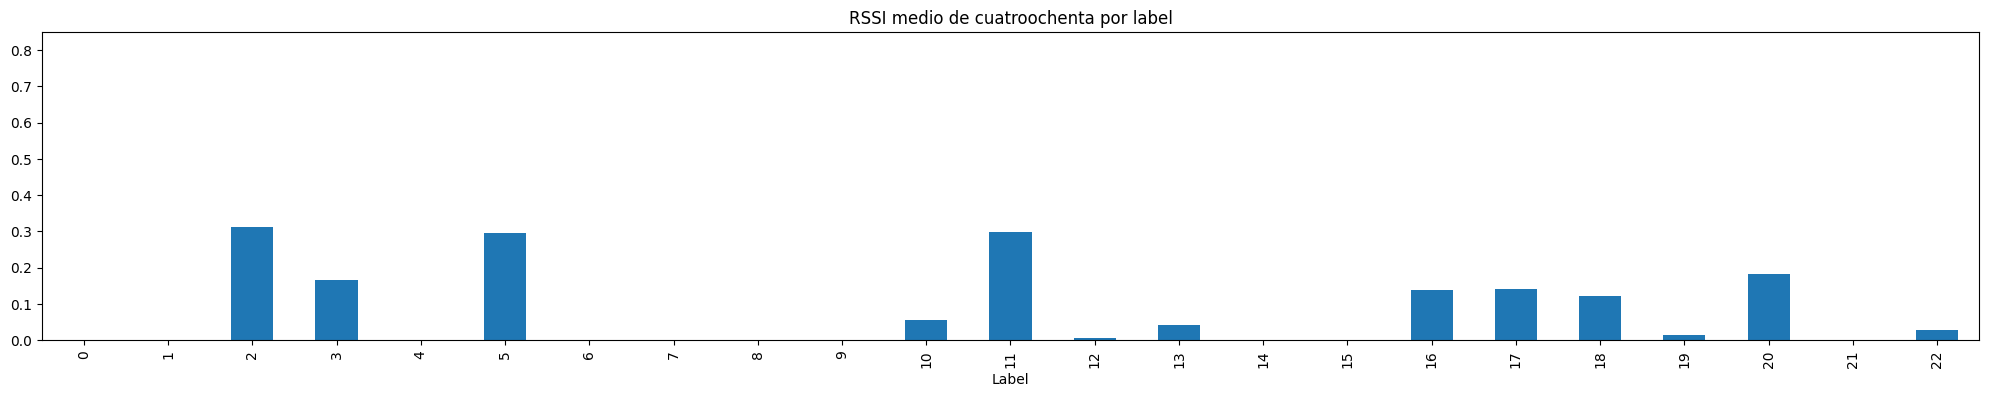

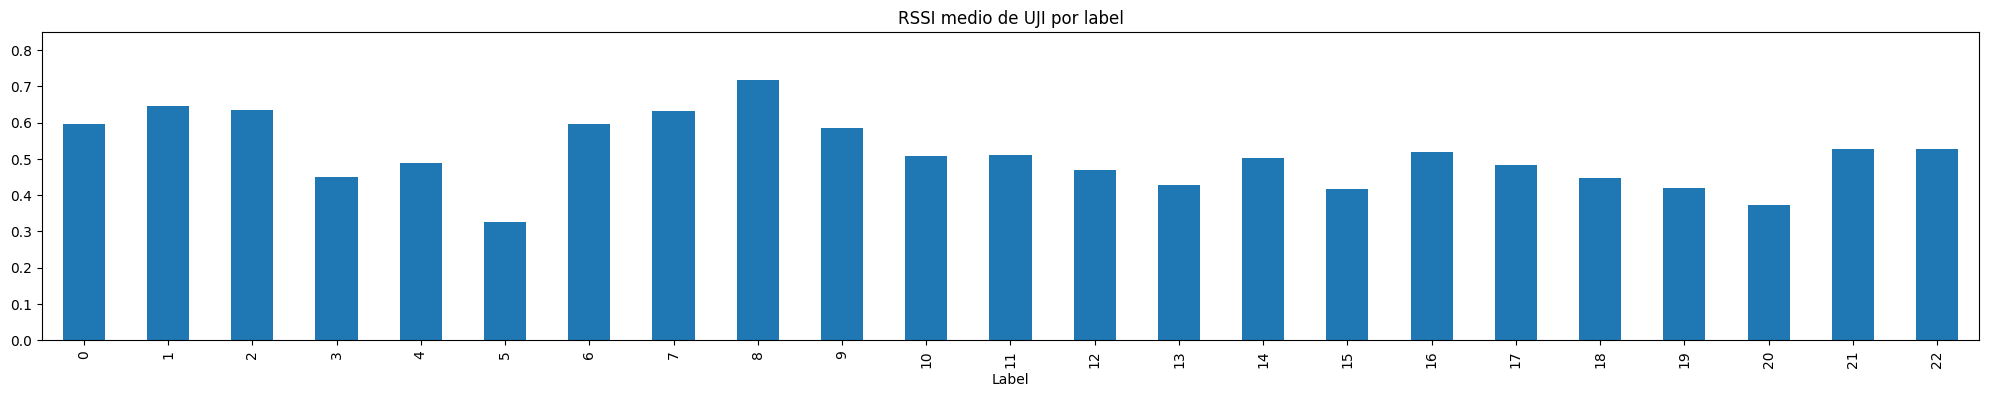

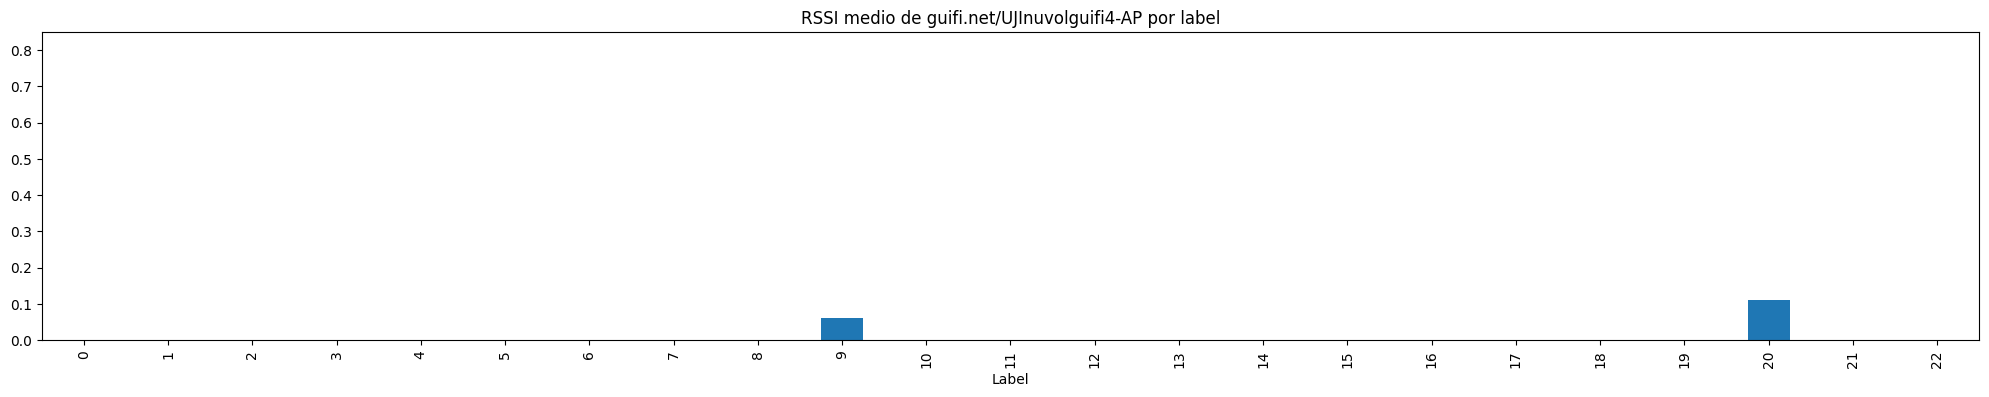

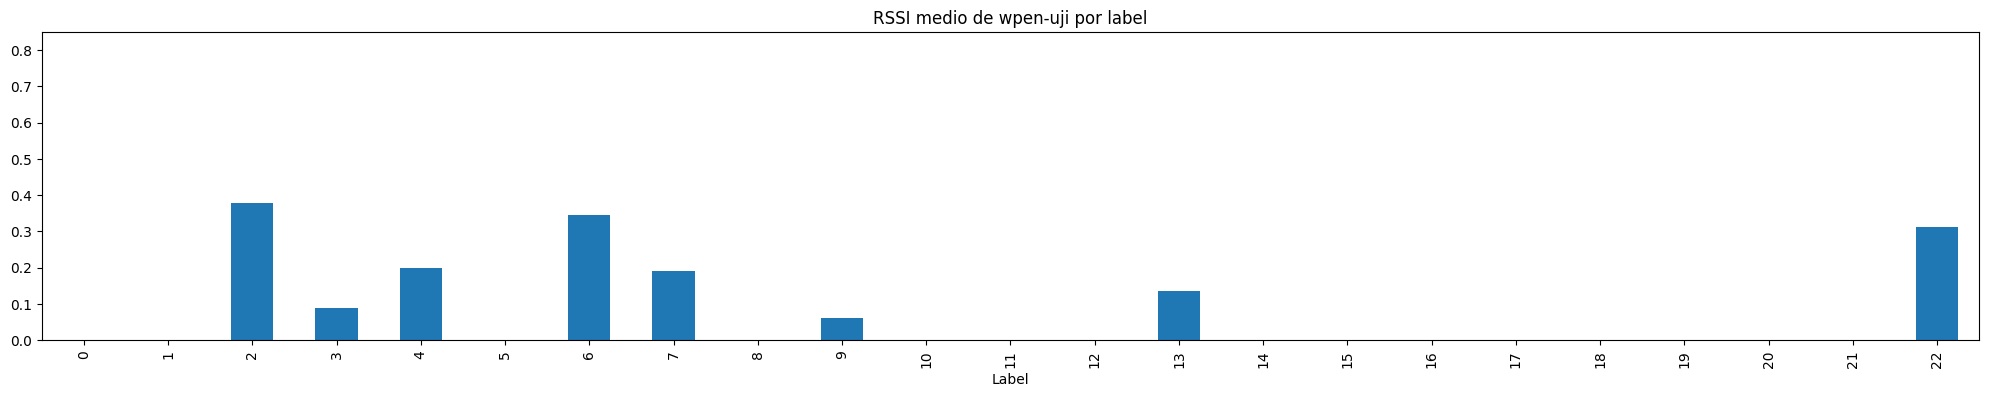

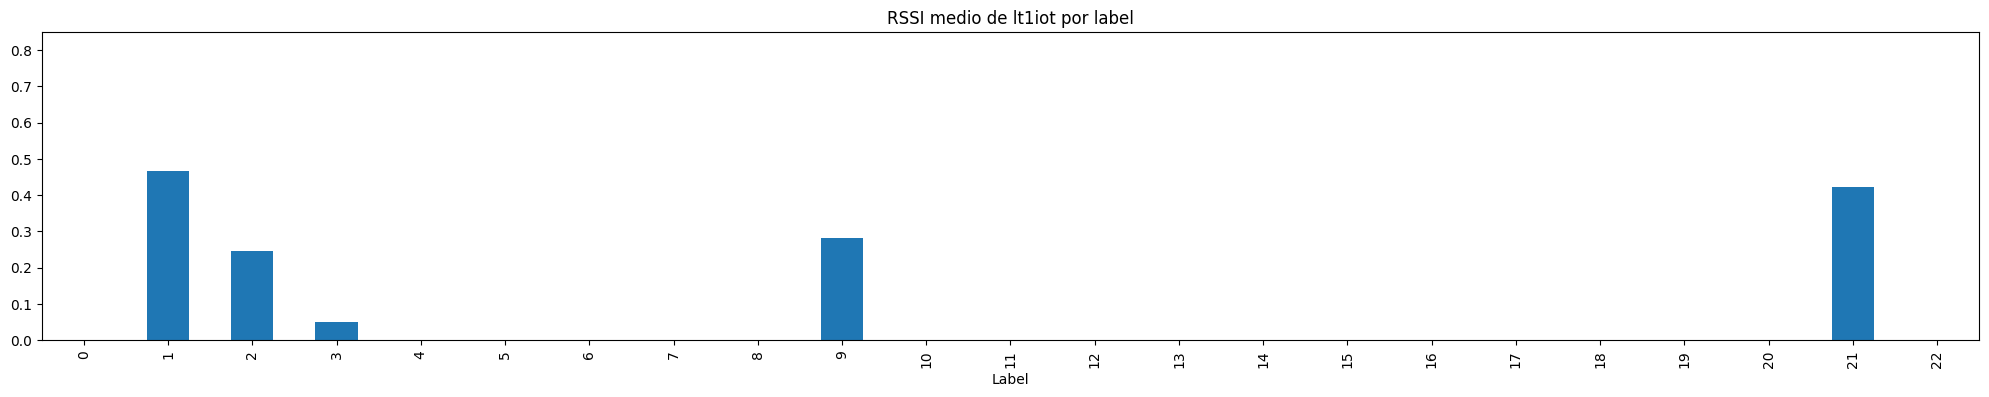

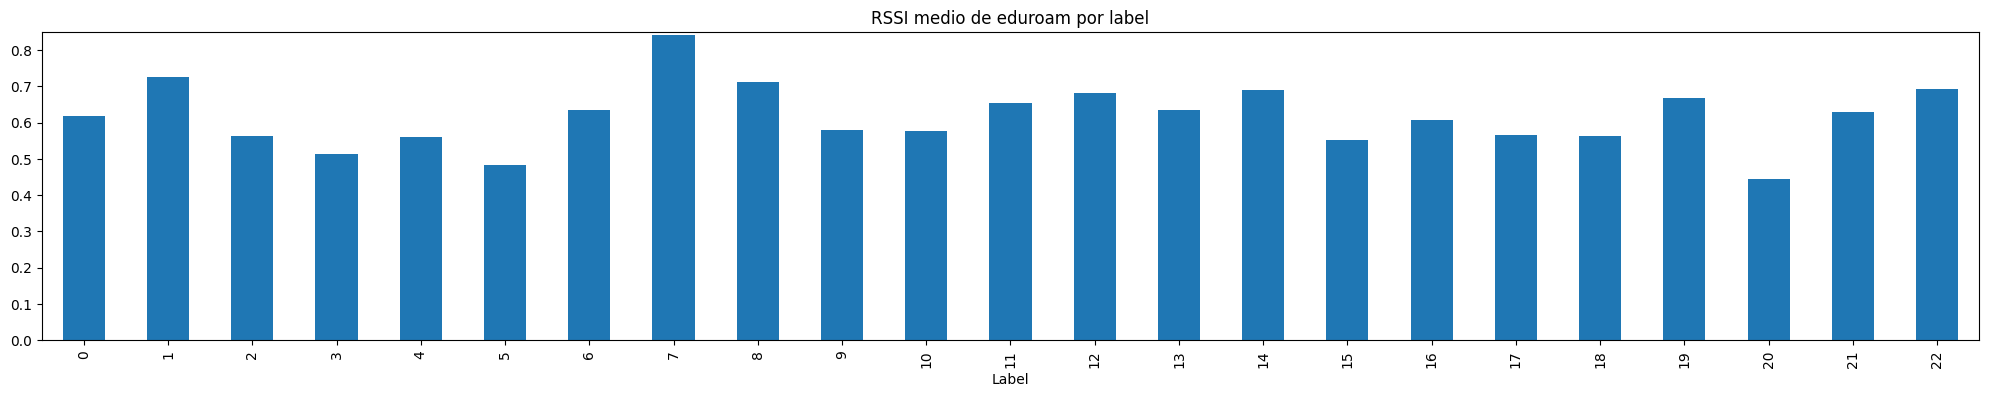

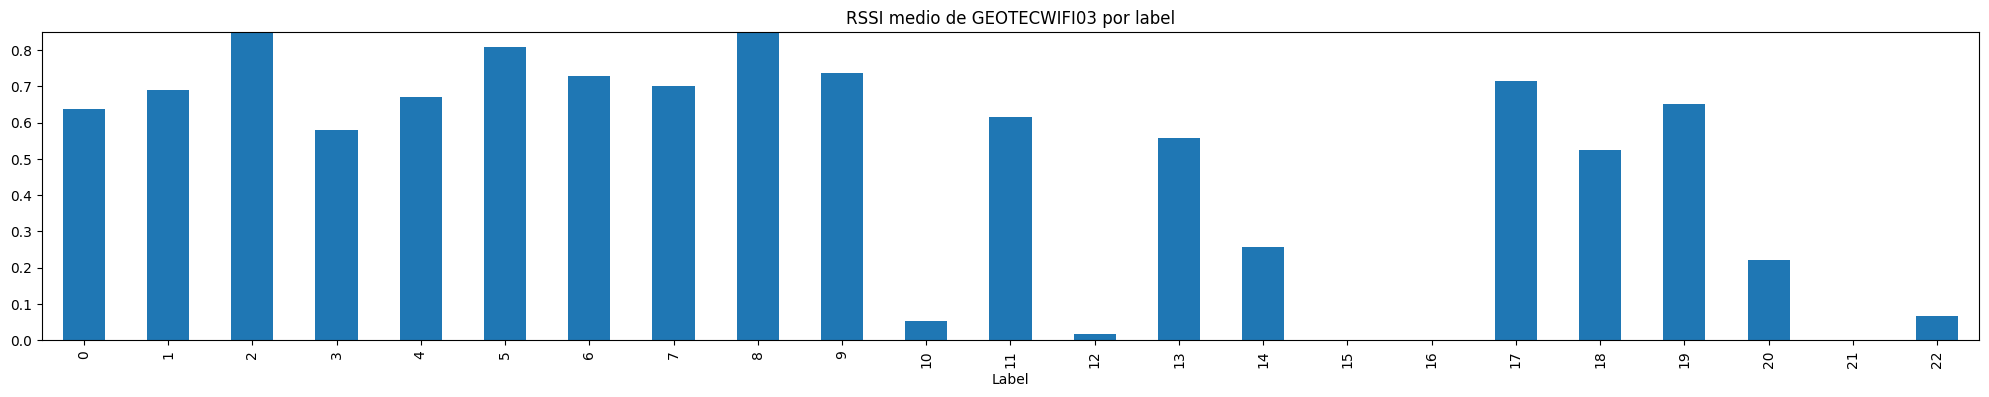

In [20]:
for wifi in wifi_columns:
    plt.figure(figsize=(25,4))
    wifi_train.groupby("Label").mean()[wifi].plot(kind="bar"); plt.title(f"RSSI medio de {wifi} por label"); plt.ylim((0,.85)); plt.show()


Eliminamos el ap de guifi.net/UJInuvolguifi4-AP al ser el que menos información aporta

In [21]:
groundtruth_interpolated = groundtruth_interpolated.drop("guifi.net/UJInuvolguifi4-AP", axis=1)
wifi_train = wifi_train.drop("guifi.net/UJInuvolguifi4-AP", axis=1)
wifi_test = wifi_test.drop("guifi.net/UJInuvolguifi4-AP", axis=1)
wifi_columns = list(set(wifi_columns) - set(["guifi.net/UJInuvolguifi4-AP"]))

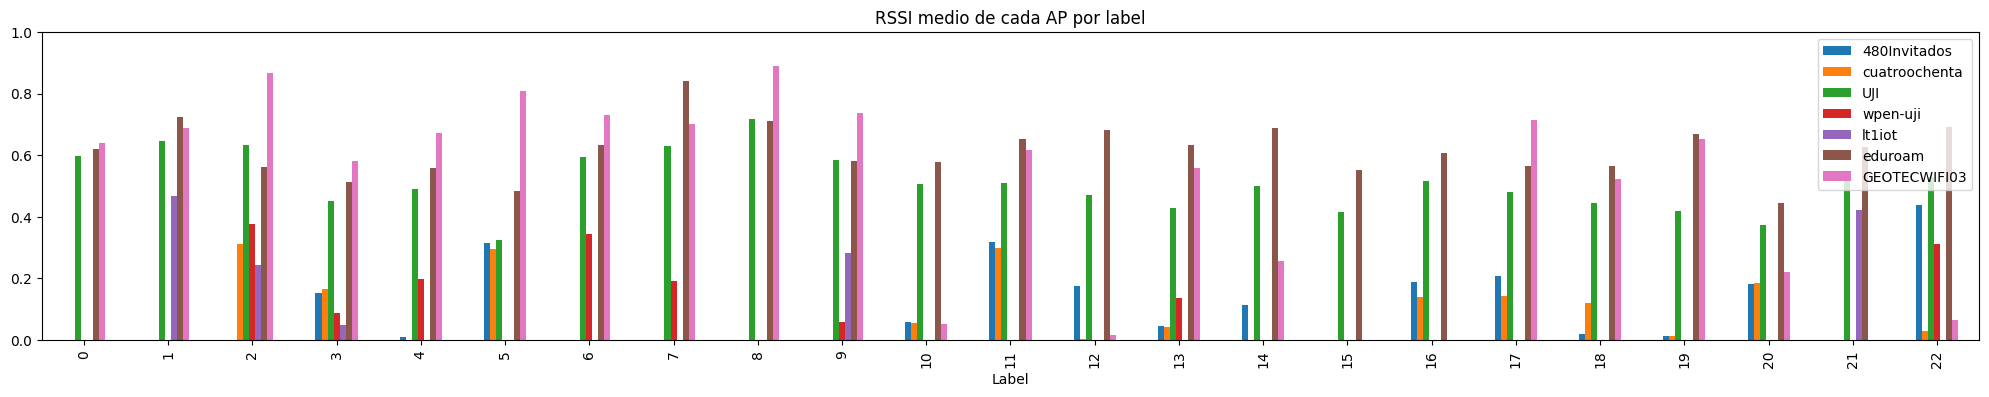

In [35]:
wifi_train.groupby("Label").mean()[wifi_columns].plot(kind="bar", figsize=(25,4)); plt.title(f"RSSI medio de cada AP por label"); plt.ylim((0,1)); plt.show()

In [36]:
intervalos = [x for x in range(wifi_train.shape[0]+1) if x%45==0]
combinaciones = [(intervalos[idx-1], x-1) for idx, x in enumerate(intervalos) if idx>0]
Xtrain = np.zeros((23, 44, 7))
ytrain = ytest = np.zeros((23, 23))
Xtest = np.zeros((23,44, 7))
for batch, pos in enumerate(combinaciones):
    Xtrain[batch, :, :] = wifi_train.iloc[pos[0]:pos[1],:7]
    ytrain[batch, :] = tf.one_hot(wifi_train.iloc[pos[0]+1]["Label"], depth=23)
    Xtest[batch, :, :] = wifi_test.iloc[pos[0]:pos[1], :7]
    ytest[batch, :] = tf.one_hot(wifi_test.iloc[pos[0]+1]["Label"], depth=23)

Xtrain = np.expand_dims(Xtrain, axis=-1)
Xtest = np.expand_dims(Xtest, axis=-1)

1/1 [==============================] - 0s 15ms/step
epoch: 46, [Discriminator :: d_loss: 0.015509], [ Generator :: loss: 0.000000]
1/1 [==============================] - 0s 19ms/step
epoch: 47, [Discriminator :: d_loss: 0.034172], [ Generator :: loss: 0.000000]
1/1 [==============================] - 0s 14ms/step
epoch: 48, [Discriminator :: d_loss: 0.028935], [ Generator :: loss: 0.000000]
1/1 [==============================] - 0s 13ms/step
epoch: 49, [Discriminator :: d_loss: 0.009920], [ Generator :: loss: 0.000000]


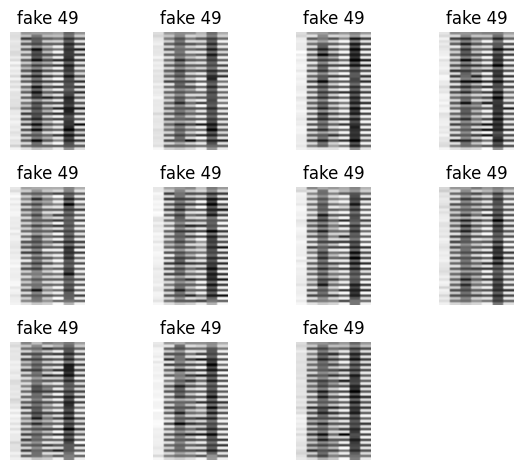

In [56]:
# Definimos el modelo

# Parámetros de entrada
in_shape=Xtrain.shape[1:]
OPTIMIZADOR_ADAM = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, decay=8e-8)

# Generador
model_gen = tf.keras.Sequential()
model_gen.add(layers.Dense(88*256, use_bias=False, input_shape=(100,)))
model_gen.add(layers.BatchNormalization())
model_gen.add(layers.LeakyReLU())
model_gen.add(layers.Reshape((22, 4, 256)))
model_gen.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
model_gen.add(layers.BatchNormalization())
model_gen.add(layers.LeakyReLU())
model_gen.add(layers.Conv2DTranspose(64, (5, 5), strides=(1, 1), padding="same", use_bias=False))
model_gen.add(layers.BatchNormalization())
model_gen.add(layers.LeakyReLU())
model_gen.add(layers.Conv2D(32, (1,2), strides=(1, 1), padding="valid", use_bias=False))

model_gen.add(layers.Conv2DTranspose(1, (1, 1), strides=(1, 1), padding='same', use_bias=False, activation='sigmoid'))
model_gen.summary()
model_gen.compile(loss='binary_crossentropy', optimizer=OPTIMIZADOR_ADAM)

# Discriminador
model_Disc = tf.keras.Sequential()
model_Disc.add(layers.Input(shape=(44,7,1)))
model_Disc.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
model_Disc.add(layers.LeakyReLU())
model_Disc.add(layers.Dropout(0.3))

model_Disc.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
model_Disc.add(layers.LeakyReLU())
model_Disc.add(layers.Dropout(0.3))

model_Disc.add(layers.Flatten())
model_Disc.add(layers.Dense(1))

model_Disc.summary()
model_Disc.compile(loss='binary_crossentropy', optimizer=OPTIMIZADOR_ADAM, metrics=['accuracy'])

# GAN
model_gan = tf.keras.models.Sequential()
model_gan.add(model_gen)
model_gan.add(model_Disc)
model_gan.compile(loss='binary_crossentropy', optimizer=OPTIMIZADOR_ADAM)

# Parámetros del entrenamiento
epochs = 50
batch = 23

# Bucle entrenamiento

DD_loss = np.zeros((epochs,))
GG_loss = np.zeros((epochs,))

os.makedirs("fingerprints_generated", exist_ok=True)

for cnt in range(epochs):

    ## Entrenamos discriminador
    # Imágenes reales
    random_index = np.random.randint(0, len(Xtrain) - np.int64(batch/2))
    legit_images = Xtrain[random_index : random_index + np.int64(batch/2)].reshape((np.int64(batch/2),)+in_shape)

    # Imágenes sintéticas
    gen_noise = np.random.normal(0, 1, (np.int64(batch/2), 100))
    syntetic_images = model_gen.predict(gen_noise)

    # Combinamos imágenes reales y sintéticas
    x_combined_batch = np.concatenate((legit_images, syntetic_images))
    y_combined_batch = np.concatenate((np.ones((np.int64(batch/2), 1)), np.zeros((np.int64(batch/2), 1))))

    plot_real_vs_fake(x_combined_batch,epoch=cnt, batch=batch)

    # Entrenamos discriminador
    d_loss = model_Disc.train_on_batch(x_combined_batch, y_combined_batch)


    ## Entrenamos generador
    # Imágenes sintéticas
    noise = np.random.normal(0, 1, (batch, 100))
    y_mislabled = np.ones((batch, 1))

    # Entremaos generador
    g_loss = model_gan.train_on_batch(noise, y_mislabled)

    ## Evolución entrenamiento
    print ('epoch: %d, [Discriminator :: d_loss: %f], [ Generator :: loss: %f]' % (cnt, d_loss[0], g_loss))

    DD_loss[cnt] = d_loss[0]
    GG_loss[cnt] = g_loss
    if cnt % 5 == 0:
        display.clear_output(wait=True)



In [ ]:
obtainEvolutionGAN()

In [ ]:
plot_model(model_gen, show_shapes=True, show_layer_activations=True, to_file="generator.png")

In [ ]:
plot_model(model_Disc, show_shapes=True, show_layer_activations=True,to_file="discriminator.png")

In [7]:
def plotHistory(DD_loss, GG_loss):
    plt.figure(figsize=(10,5))
    plt.plot(DD_loss, label="Discriminator")
    plt.plot(GG_loss, label="Generator")
    plt.legend()
    plt.show()

plotHistory(DD_loss, GG_loss)

NameError: name 'DD_loss' is not defined

# Construir GAN condicional
$[RSSI_{AP_1}, RSSI_{AP_1}, \ldots, RSSI_{AP_8} ]|RP$

In [8]:
intervalos = [x for x in range(wifi_train.shape[0]+1) if x%45==0]
combinaciones = [(intervalos[idx-1], x-1) for idx, x in enumerate(intervalos) if idx>0]
Xtrain = np.zeros((23, 44, 8))
ytrain = ytest = np.zeros((23, 1))
Xtest = np.zeros((23,44, 8))
for batch, pos in enumerate(combinaciones):
    Xtrain[batch, :, :] = wifi_train.iloc[pos[0]:pos[1],:8]
    ytrain[batch, ] = wifi_train.iloc[pos[0]+1]["Label"]
    Xtest[batch, :, :] = wifi_test.iloc[pos[0]:pos[1], :8]
    ytest[batch, ] = wifi_test.iloc[pos[0]+1]["Label"]

Xtrain = np.expand_dims(Xtrain, axis=-1)
Xtest = np.expand_dims(Xtest, axis=-1)

In [191]:
ytrain

array([[ 0.],
       [ 1.],
       [ 2.],
       [ 3.],
       [ 4.],
       [ 5.],
       [ 6.],
       [ 7.],
       [ 8.],
       [ 9.],
       [10.],
       [11.],
       [12.],
       [13.],
       [14.],
       [15.],
       [16.],
       [17.],
       [18.],
       [19.],
       [20.],
       [21.],
       [22.]])

In [12]:
in_shape = (np.shape(Xtrain)[1], 1)
n_classes = int(np.max(ytrain)+1)
n_nodes = in_shape[0] * in_shape[1]
latent_dim = 100
features = Xtrain.shape[1]
OPTIMIZADOR_ADAM = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, decay=8e-8)

def define_conditional_generator():
    # Generador de condicional
    label_input_gen = layers.Input(shape=(1,), name="label_input_gen")
    label_embedding_gen = layers.Embedding(n_classes, 8)(label_input_gen)
    n_nodes = 11*2*256 # Shape objetivo = (44, 8, 1) -> 11*2*2, 2*2*2, 1)
    li = layers.Dense(n_nodes, name="embedding_dense")(label_embedding_gen)
    li = layers.Reshape((11, 2, 256))(li)
    noise = layers.Input(shape=(latent_dim,), name="noise")

    gen = layers.Dense(n_nodes)(noise)
    gen = layers.LeakyReLU(alpha=0.2)(gen)
    gen = layers.Reshape((11, 2, 256))(gen)
    merge = layers.Concatenate()([gen, li])
    gen = layers.Conv2DTranspose(128, 4, strides=2, padding='same')(merge)
    gen = layers.LeakyReLU(alpha=0.2)(gen)
    gen = layers.Conv2DTranspose(128, 4, strides=2, padding='same')(gen)
    gen = layers.LeakyReLU(alpha=0.2)(gen)
    out_layer = layers.Conv2DTranspose(1, 1, strides=1, padding='same', activation='sigmoid')(gen)

    generator = tf.keras.Model([noise, label_input_gen], out_layer, name="generator")
    # generator.compile(loss='binary_crossentropy', optimizer=OPTIMIZADOR_ADAM)
    return generator

def define_conditional_discriminator():
    label_input_disc = layers.Input(shape=(1,), name="label_input_disc")
    label_embedding_disc = layers.Embedding(n_classes, 8)(label_input_disc)
    n_nodes = 44*8*1 # Shape objetivo = (44, 8, 1)
    li = layers.Dense(n_nodes, name="embedding_dense")(label_embedding_disc)
    li = layers.Reshape((44, 8, 1))(li)

    in_layer = layers.Input(shape=(44,8,1), name="input_img")
    merge = layers.Concatenate()([in_layer, li])
    disc = layers.Conv2D(128, 3, strides=2, padding='same')(merge)
    disc = layers.LeakyReLU(alpha=0.2)(disc)
    disc = layers.Dropout(0.4)(disc)
    disc = layers.Conv2D(128, 3, strides=2, padding='same')(disc)
    disc = layers.LeakyReLU(alpha=0.2)(disc)
    disc = layers.Dropout(0.4)(disc)
    disc = layers.Flatten()(disc)
    out_layer = layers.Dense(1, activation='sigmoid')(disc)
    discriminator = tf.keras.Model([in_layer, label_input_disc], out_layer, name="discriminator")
    discriminator.compile(loss='binary_crossentropy', optimizer=OPTIMIZADOR_ADAM, metrics=['accuracy'])
    return discriminator

def define_conditional_gan(discriminator, generator):
    # GAN
    # gan_conditional = tf.keras.models.Sequential()
    # gan_conditional.add(discriminator_conditional)
    # gan_conditional.add(generator_conditional)
    # gan_conditional.compile(loss='binary_crossentropy', optimizer=OPTIMIZADOR_ADAM)

     # make the discriminator layer as non trainable
    discriminator.trainable = False
    # get the noise and label input from the generator
    gen_noise, gen_label = generator.input
    # get the output from the generator
    gen_output = generator.output
    #connect image output and label input from generator as inputs to      #discriminator
    gan_output = generator([gen_output,gen_label])
    #define gan model as taking noise and label and outputting a #classification
    gan_conditional = tf.keras.models.Model([gen_noise,gen_label],gan_output)
    gan_conditional.compile(loss='binary_crossentropy', optimizer=OPTIMIZADOR_ADAM)

    # discriminator = define_conditional_discriminator()
    # generator = define_conditional_generator()
    # noise, label_input = generator.input
    # generator = generator([noise, label_input])
    # gan_output = discriminator([generator, label_input])
    # gan = tf.keras.Model([noise, label_input], gan_output)
    # gan.compile(loss='binary_crossentropy', optimizer=OPTIMIZADOR_ADAM)
    return gan_conditional

# Definimos el discriminador, generador y GAN
discriminator_conditional = define_conditional_discriminator()
generator_conditional = define_conditional_generator()
gan_conditional = define_conditional_gan(discriminator_conditional, generator_conditional)

ValueError: Exception encountered when calling layer "generator" (type Functional).

Input 0 of layer "dense_7" is incompatible with the layer: expected axis -1 of input shape to have value 100, but received input with shape (None, 44, 8, 1)

Call arguments received by layer "generator" (type Functional):
  • inputs=['tf.Tensor(shape=(None, 44, 8, 1), dtype=float32)', 'tf.Tensor(shape=(None, 1), dtype=float32)']
  • training=False
  • mask=None

# Modelo Generador


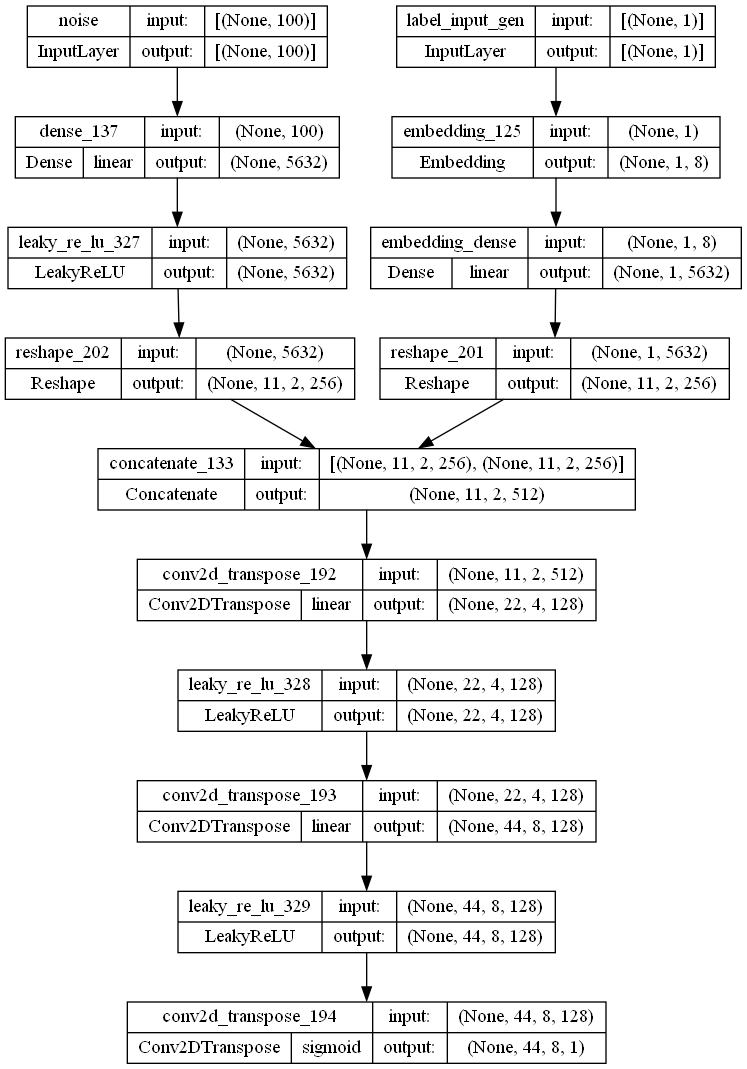

In [74]:
plot_model(generator_conditional, show_shapes=True, show_layer_activations=True, to_file='generator_conditional.png')

# Modelo Discriminador

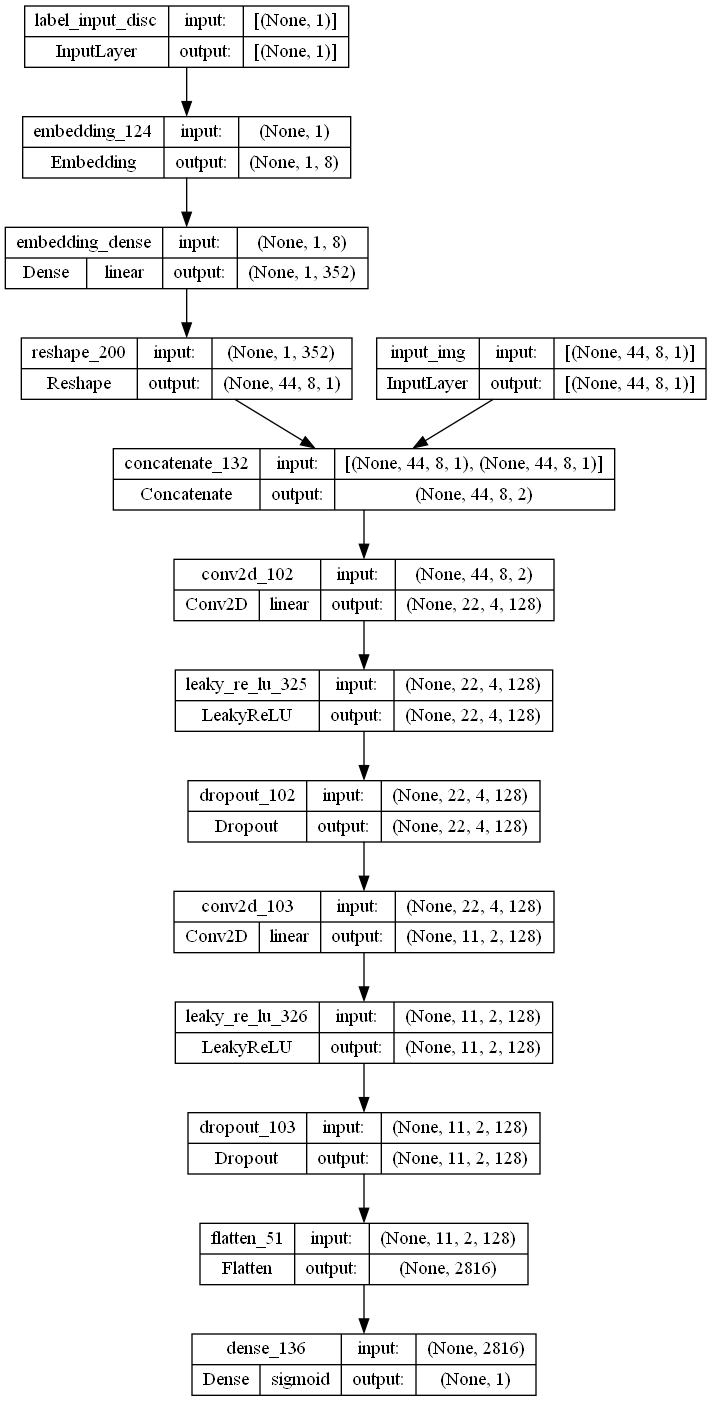

In [75]:
plot_model(discriminator_conditional, show_shapes=True, show_layer_activations=True, to_file='discriminator_conditional.png')

# Modelo GAN

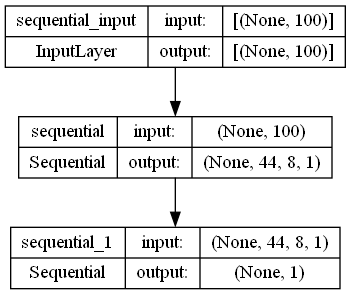

In [219]:
plot_model(gan_conditional, show_shapes=True, show_layer_activations=True, to_file='gan_conditional.png')

# Entrenamiento GAN condicional

In [217]:
epochs=3
batch=23
half_batch = np.int64(batch/2)
for cnt in range(epochs):
    random_index = np.random.randint(0, len(Xtrain) - half_batch)
    legit_images = Xtrain[random_index : random_index + half_batch].reshape((half_batch,)+Xtrain.shape[1:])
    legit_labels = ytrain[random_index : random_index + half_batch]

    noise = np.random.normal(0, 1, (half_batch, 100))
    syntetic_labels = np.random.randint(0, n_classes, half_batch).reshape(-1, 1)
    syntetic_images = generator_conditional.predict([noise, syntetic_labels])

    x_combined_batch = np.concatenate((legit_images, syntetic_images))
    y_combined_batch = np.concatenate((np.ones((half_batch, 1)), np.zeros((half_batch, 1))))

    labels_combined_batch = np.concatenate((legit_labels, syntetic_labels))

    d_loss = discriminator_conditional.train_on_batch([x_combined_batch, labels_combined_batch], y_combined_batch)

    y_mislabled = np.ones((batch, 1))
    g_loss = generator_conditional.train_on_batch([noise, syntetic_labels], y_mislabled)
    print("kjhnaslkjnsfkjnsfdg")
    ## Evolución entrenamiento
    print ('epoch: %d, [Discriminator :: d_loss: %f], [ Generator :: loss: %f]' % (cnt, d_loss[0], g_loss))

    DD_loss[cnt] = d_loss[0]
    GG_loss[cnt] = g_loss
    if cnt % 5 == 0:
        display.clear_output(wait=True)

1/1 [==============================] - 0s 18ms/step


ValueError: Data cardinality is ambiguous:
  x sizes: 11, 11
  y sizes: 23
Make sure all arrays contain the same number of samples.

# Entrenamiento GAN que genere imagenes del RSSI de cada wifi en todo el espacio (latitud, longitud):
$RSSI_{AP}|RP_{continuo}$

Dado que tenemos 23 puntos discretos o Reference Points (latitud, longitud) de recogida de datos de todos los wifis. En primer lugar tenemos que generar un mallado continuo de imágenes donde para cada latitud y longitud posible en el espacio, tengamos un valor RSSI generado de cada WiFi

Si recogemos la media de todos los RSS recogidos de un AP en cada Reference Point tendríamos algo similar a la siguiente imagen

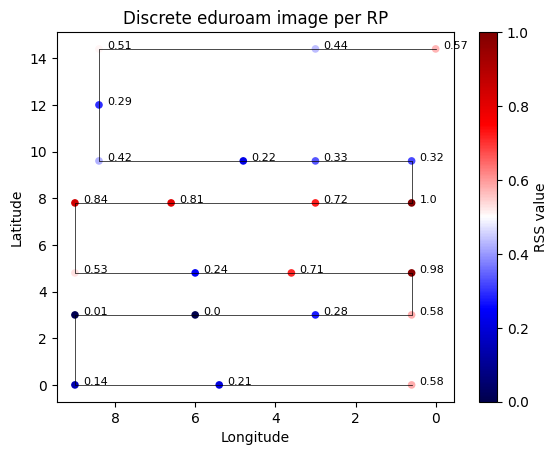

In [15]:
aux = groundtruth_interpolated.groupby(["Latitude", "Longitude", "Label"]).mean("eduroam").reset_index()
aux = aux.sort_values(by="Label").drop("Label", axis=1)
min_eduroam, max_eduroam = aux.eduroam.min(), aux.eduroam.max()
aux["eduroam"] = (aux["eduroam"] - min_eduroam) / (max_eduroam - min_eduroam)
plt.scatter(aux["Longitude"], aux["Latitude"], s=20, marker='o', c=aux["eduroam"], cmap="seismic")
plt.plot(aux["Longitude"], aux["Latitude"], linestyle='-', color='k', linewidth=0.5)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title(f"Discrete eduroam image per RP")
cbar = plt.colorbar()
cbar.set_label('RSS value')
ax = plt.gca()
ax.invert_xaxis()
# Añadimos texto en cada punto de recogida de datos
for idx, row in aux.iterrows():
    plt.text(row["Longitude"]-0.2, row["Latitude"], str(row["eduroam"].round(2)), fontsize=8)
plt.savefig("fig_example.png")
plt.show()

Con las funciones interpolateAPIamge y plotInterpolatedAPImage, implementadas en imutils, podemos generar una imagen continua de un AP en todo el espacio

In [22]:
groundtruth_interpolated.columns

Index(['AppTimestamp(s)', 'eduroam', 'UJI', 'wpen-uji', 'GEOTECWIFI03',
       'lt1iot', 'cuatroochenta', 'guifi.net/UJInuvolguifi4-AP',
       '480Invitados', 'Acc_X', 'Acc_Y', 'Acc_Z', 'Gyr_X', 'Gyr_Y', 'Gyr_Z',
       'Mag_X', 'Mag_Y', 'Mag_Z', 'Latitude', 'Longitude', 'Label'],
      dtype='object')

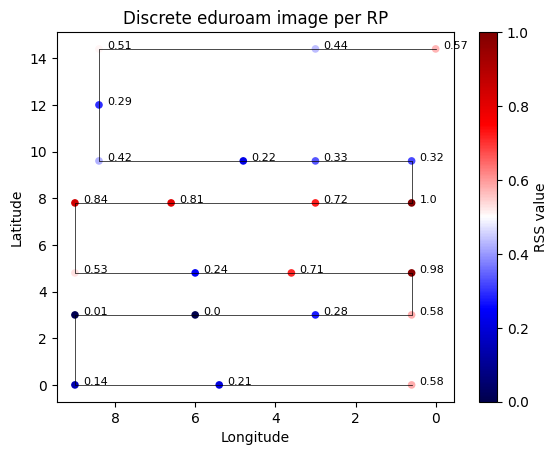

C:\Users\javie\Desktop\SISTEMAS INTELIGENTES\TFM\getsensordata2\imutils.py:264: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  aux2 = aux.drop([ap], 1)


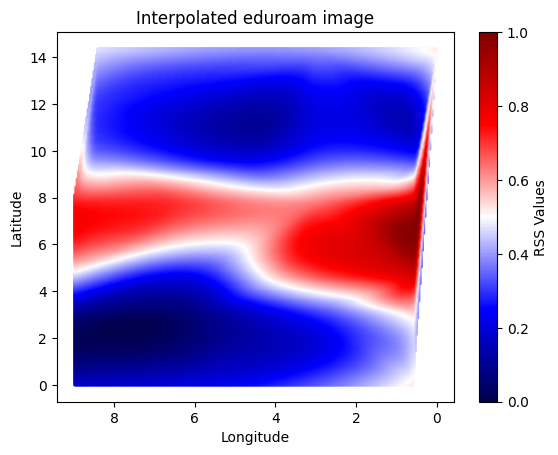

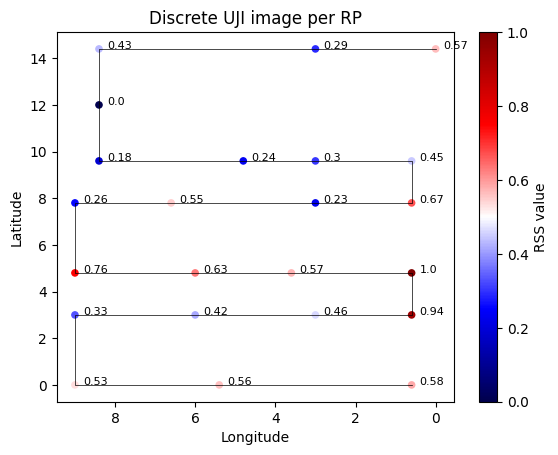

C:\Users\javie\Desktop\SISTEMAS INTELIGENTES\TFM\getsensordata2\imutils.py:264: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  aux2 = aux.drop([ap], 1)


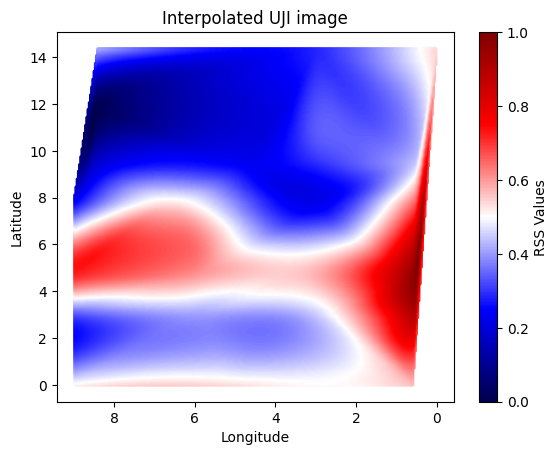

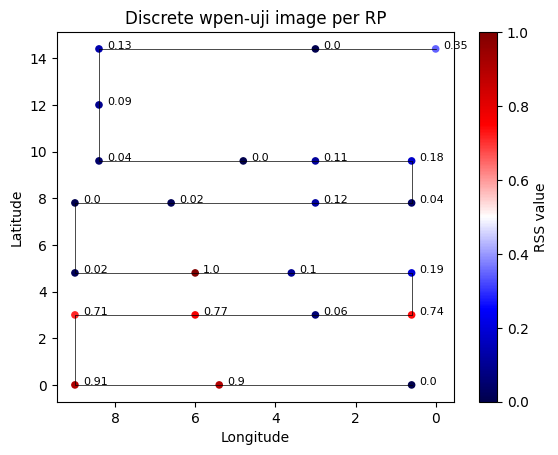

C:\Users\javie\Desktop\SISTEMAS INTELIGENTES\TFM\getsensordata2\imutils.py:264: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  aux2 = aux.drop([ap], 1)


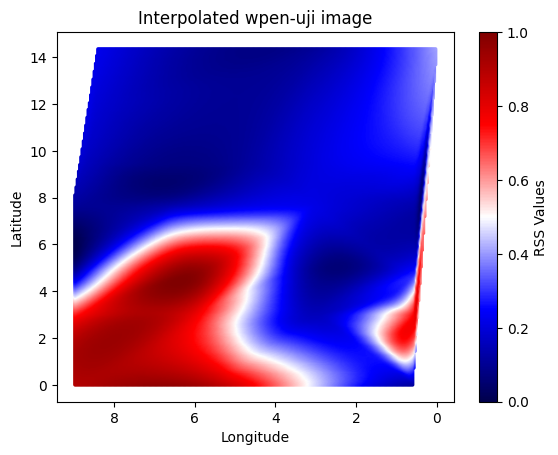

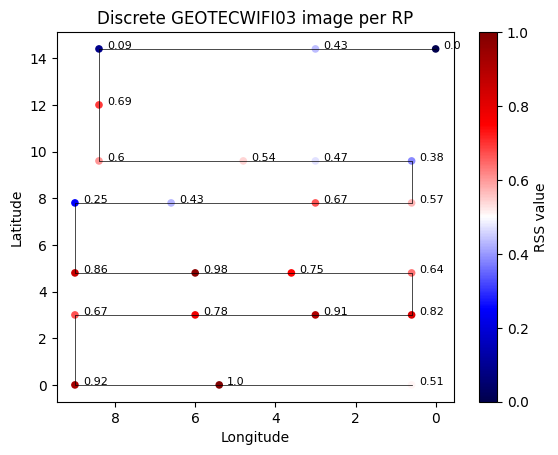

C:\Users\javie\Desktop\SISTEMAS INTELIGENTES\TFM\getsensordata2\imutils.py:264: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  aux2 = aux.drop([ap], 1)


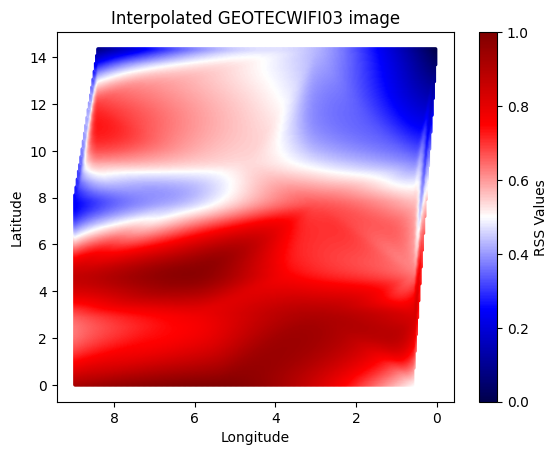

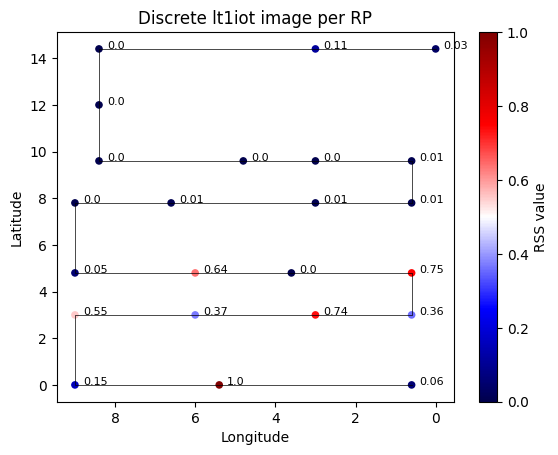

C:\Users\javie\Desktop\SISTEMAS INTELIGENTES\TFM\getsensordata2\imutils.py:264: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  aux2 = aux.drop([ap], 1)


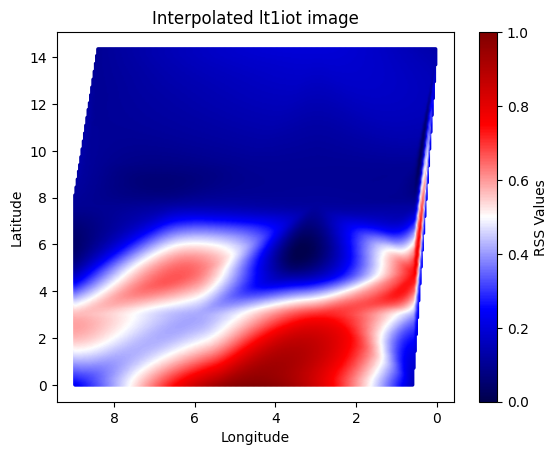

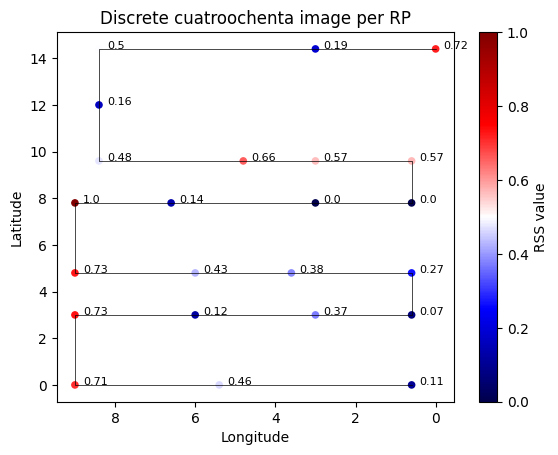

C:\Users\javie\Desktop\SISTEMAS INTELIGENTES\TFM\getsensordata2\imutils.py:264: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  aux2 = aux.drop([ap], 1)


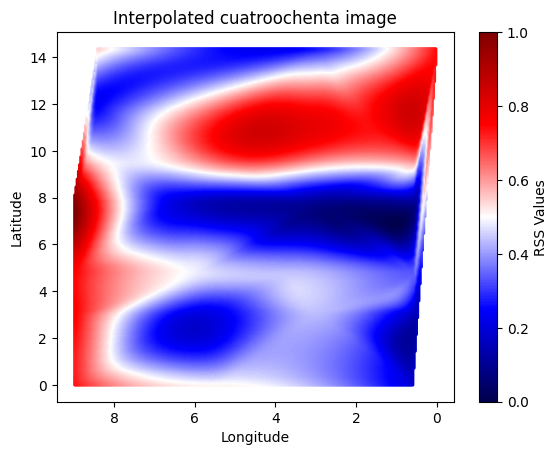

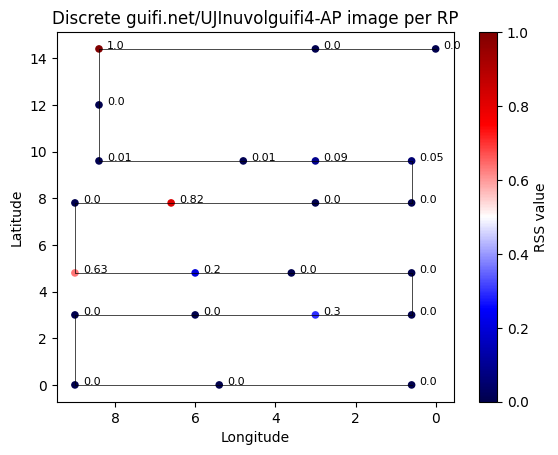

C:\Users\javie\Desktop\SISTEMAS INTELIGENTES\TFM\getsensordata2\imutils.py:264: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  aux2 = aux.drop([ap], 1)


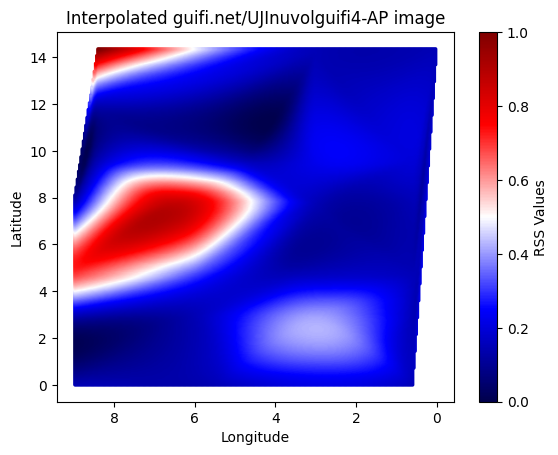

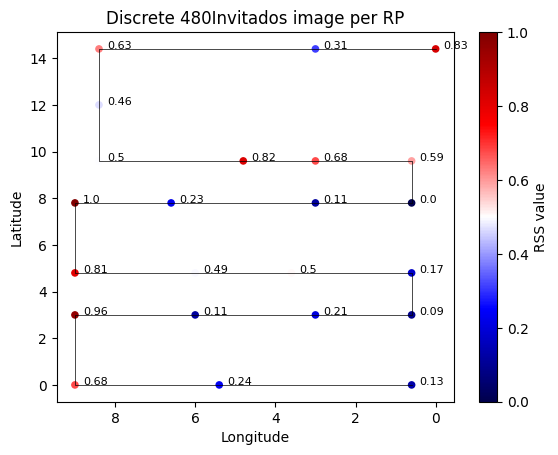

C:\Users\javie\Desktop\SISTEMAS INTELIGENTES\TFM\getsensordata2\imutils.py:264: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  aux2 = aux.drop([ap], 1)


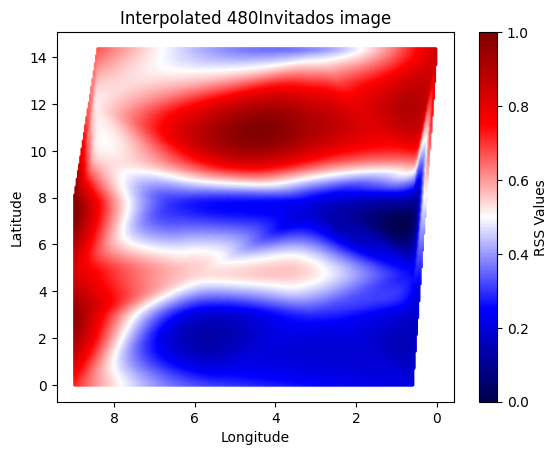

In [26]:

for ap in ['eduroam', 'UJI', 'wpen-uji', 'GEOTECWIFI03', 'lt1iot', 'cuatroochenta',
          'guifi.net/UJInuvolguifi4-AP', '480Invitados']:

    aux = groundtruth_interpolated.groupby(["Latitude", "Longitude", "Label"]).mean(ap).reset_index()
    aux = aux.sort_values(by="Label").drop("Label", axis=1)
    min_eduroam, max_eduroam = aux[ap].min(), aux[ap].max()
    aux[ap] = (aux[ap] - min_eduroam) / (max_eduroam - min_eduroam)
    plt.scatter(aux["Longitude"], aux["Latitude"], s=20, marker='o', c=aux[ap], cmap="seismic")
    plt.plot(aux["Longitude"], aux["Latitude"], linestyle='-', color='k', linewidth=0.5)
    plt.ylabel('Latitude')
    plt.xlabel('Longitude')
    plt.title(f"Discrete {ap} image per RP")
    cbar = plt.colorbar()
    cbar.set_label('RSS value')
    ax = plt.gca()
    ax.invert_xaxis()
    # Añadimos texto en cada punto de recogida de datos
    for idx, row in aux.iterrows():
        plt.text(row["Longitude"]-0.2, row["Latitude"], str(row[ap].round(2)), fontsize=8)
    plt.savefig("fig_example.png")
    plt.show()

    x_g, y_g, grid_z0 = interpolateAPImage(df=groundtruth_interpolated,
                                          ap=ap)


    plt.scatter(x_g, y_g, s=2, marker='o', c=grid_z0, cmap="seismic")
    plt.ylabel('Latitude')
    plt.xlabel('Longitude')
    plt.title(f"Interpolated {ap} image")
    cbar = plt.colorbar()
    cbar.set_label('RSS Values')
    plt.gca().invert_xaxis()
    plt.axis('on')
    plt.savefig("fig_example_continuous.png")
    plt.show()


# Análisis Exploratorio

In [ ]:
import process_groundTruth, tqdm
wifi_data = pd.DataFrame(
        columns=['AppTimestamp(s)', 'SensorTimeStamp(s)', 'Name_SSID', 'MAC_BSSID', 'RSS']
    )

with open('logfile_2023_10_10_09_17_34.txt', 'r') as fich:
    for linea in fich.readlines():  # Leemos línea
        texto = linea.rstrip("\n").split(";")
        if texto[0] == "WIFI":  # Si el primer elemento es ACCE, añadimos datos al acelerómetro
            wifi_data = pd.concat([wifi_data,
                                    pd.DataFrame({
                                           "AppTimestamp(s)": [float(texto[1])],
                                           "SensorTimeStamp(s)": [float(texto[2])],
                                           "Name_SSID": [texto[3]],
                                           "MAC_BSSID": [texto[4]],
                                           "RSS": [float(texto[5])],
                                           "Label": [0],
                                           "Latitude": [0.6],
                                           "Longitude": [0]
                                       })
                                       ])
lista_ssid_candidatos = wifi_data.Name_SSID.unique().tolist()
aux = wifi_data.copy()
intervalos_tiempo, ssids = [], []
for ts in range(0, int(wifi_data["AppTimestamp(s)"].max().round()), 1):
    for ssid in lista_ssid_candidatos:
        intervalos_tiempo.append(ts)
        ssids.append(ssid)

df_intervalos = pd.DataFrame({'AppTimestamp(s)': intervalos_tiempo, 'Name_SSID': ssids})

min_global = aux.RSS.min() - 1

aux["AppTimestamp(s)"] = aux["AppTimestamp(s)"].round()
aux = aux.groupby(["AppTimestamp(s)", "Name_SSID"]).mean()["RSS"].reset_index()
aux_corrected = pd.merge(df_intervalos, aux, on=["AppTimestamp(s)", "Name_SSID"], how="left")
aux_corrected["RSS"] = aux_corrected.RSS.replace(np.nan, min_global)
aux_corrected = aux_corrected.pivot(index='AppTimestamp(s)', columns='Name_SSID')["RSS"].reset_index()
# aux_corrected.iloc[:, 1:] = (aux_corrected.iloc[:, 1:] - min_global) / max_global

aux_corrected.iloc[:, 1:] = (aux_corrected.iloc[:, 1:] - min_global)
max_global = aux_corrected.iloc[:,1:].max().max()
aux_corrected.iloc[:,1:] /= max_global

aux_corrected[["Longitude", "Latitude", "Label"]] = (0.6, 0, 0)
orden_wifi_columnas = ["AppTimestamp(s)"] + \
                      [x for x in aux_corrected.columns if
                       x not in ["AppTimestamp(s)", "Latitude", "Longitude", "Label"]] + \
                      ["Latitude", "Longitude", "Label"]
wifi_corrected = aux_corrected[orden_wifi_columnas]


In [ ]:
for data in [wifi_corrected, wifi_corrected_inter]:
    plt.figure(figsize=(25,4))
    for wifi in data.columns.tolist()[1:]:
        if wifi in ["480Invitados", "GEOTECWIFI03", "MOVISTAR_E95D", "UJI"]:
            plt.plot(data["AppTimestamp(s)"], data[wifi], label=wifi, alpha=0.6);  plt.xlim((1800, 2000))
    plt.legend()
    plt.show()